# Notebook for a controlled Bursting gene Chemical Reaction Network

Bursting Gene Chemical Reaction Network:

\begin{equation}
    \emptyset \xrightleftharpoons[\xi]{\theta_1} S_1 \quad
    S_1 \xrightarrow{\theta_2} S_1+S_2 \quad
    S_2 \xrightarrow{\theta_3} \emptyset
\end{equation}

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib.pyplot as plt

import neuralnetwork
import convert_csv
import plot
import save_load_MDN
import training_pgd
import simulation

from CRN4_control import propensities_bursting_gene as propensities

## Import data

In [2]:
FILE_NAME = 'data'
CRN_NAME = 'controlled_bg'
NUM_PARAMS = 7

In [3]:
# loading data
X_train1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train1.csv')
X_train2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train2.csv')
X_train3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train3.csv')

y_train1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train1.csv')
y_train2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train2.csv')
y_train3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train3.csv')

X_valid1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid1.csv')
X_valid2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid2.csv')
X_valid3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid3.csv')

y_valid1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid1.csv')
y_valid2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid2.csv')
y_valid3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid3.csv')

X_test = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_test.csv')
y_test = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_test.csv')

train_data1 = [X_train1, y_train1]
valid_data1 = [X_valid1, y_valid1]
train_data2 = [X_train2, y_train2]
valid_data2 = [X_valid2, y_valid2]
train_data3 = [X_train3, y_train3]
valid_data3 = [X_valid3, y_valid3]

## Hyperparameters

In [4]:
LR = 0.005
N_ITER = 700
N_HIDDEN = 128
BATCHSIZE = 32
MIXTURE = 'NB'
N_COMPS = 4

## Training models

We train 3 different models to compare their accuracy.

In [5]:
model1 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)
model2 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)
model3 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)

Mixture Density Network created.
Mixture Density Network created.
Mixture Density Network created.


In [6]:
train_losses1, valid_losses1 = neuralnetwork.train_NN(model1, train_data1, valid_data1, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)
train_losses2, valid_losses2 = neuralnetwork.train_NN(model2, train_data2, valid_data2, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)
train_losses3, valid_losses3 = neuralnetwork.train_NN(model3, train_data3, valid_data3, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)

Training ...: 100%|█████████▉| 699/700 [26:53<00:02,  2.31s/it]


Learning rate: 2.5177519986929707e-08,
Train loss: 0.0008746866951696575,
 Valid loss: 0.0009114354616031051


Training ...: 100%|█████████▉| 699/700 [31:19<00:02,  2.69s/it]


Learning rate: 2.5177519986929707e-08,
Train loss: 0.0008430646848864853,
 Valid loss: 0.0008377252379432321


Training ...: 100%|█████████▉| 699/700 [30:56<00:02,  2.66s/it]

Learning rate: 2.5177519986929707e-08,
Train loss: 0.000844088033773005,
 Valid loss: 0.0008394132019020617


In [11]:
for i, model in enumerate([model1, model2, model3]):
    save_load_MDN.save_MDN_model(model, f'CRN4_model{i+1}_long.pt')

## Loading models

In [5]:
model1 = save_load_MDN.load_MDN_model('saved_models/CRN4_model1.pt')
model2 = save_load_MDN.load_MDN_model('saved_models/CRN4_model2.pt')
model3 = save_load_MDN.load_MDN_model('saved_models/CRN4_model3.pt')

Mixture Density Network created.
Mixture Density Network created.
Mixture Density Network created.


In [6]:
# Compute losses

print("Model 1")
print(f"KLD : {neuralnetwork.mean_loss(X_test, y_test, model1, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_test, y_test, model1, loss=neuralnetwork.loss_hellinger)}')

print("Model 2")
print(f"KLD : {neuralnetwork.mean_loss(X_test, y_test, model2, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_test, y_test, model2, loss=neuralnetwork.loss_hellinger)}')

print("Model 3")
print(f"KLD : {neuralnetwork.mean_loss(X_test, y_test, model3, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_test, y_test, model3, loss=neuralnetwork.loss_hellinger)}')


Model 1
KLD : 0.0009744386188685894
Hellinger : 0.014159342274069786
Model 2
KLD : 0.0009031827794387937
Hellinger : 0.013765959069132805
Model 3
KLD : 0.0009370129555463791
Hellinger : 0.014034893363714218


## Distributions plot


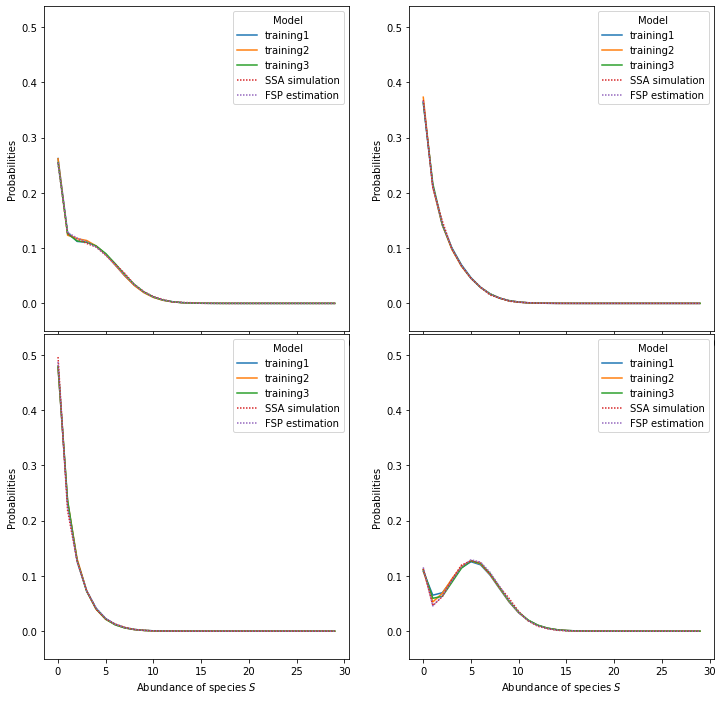

In [7]:
plot.multiple_plots(to_pred=[X_test[1_000+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = 4*[30], 
                    time_windows = np.array([5, 10, 15, 20]),
                    n_comps=N_COMPS,
                    plot_test_result=(True, [y_test[1_000+k,:] for k in range(4)]), 
                    plot_fsp_result=(True, 
                                    propensities.stoich_mat, 
                                    propensities.propensities, 
                                    None,
                                    50, 
                                    propensities.init_state, 
                                    1, 
                                    3, 
                                    1))

## Sentivities plot

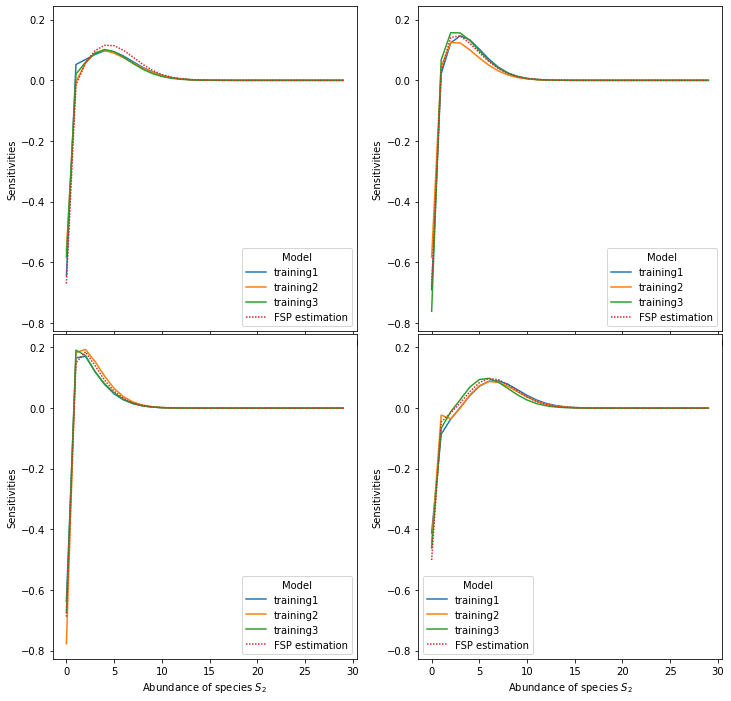

In [8]:
plot.multiple_plots(to_pred=[X_test[1_000+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound=[30]*4, 
                    time_windows=np.array([5, 10, 15, 20]),
                    n_comps=N_COMPS,
                    plot=('sensitivities', 0), 
                    plot_fsp_result=(True, 
                                    propensities.stoich_mat, 
                                    propensities.propensities, 
                                    None,
                                    50, 
                                    propensities.init_state, 
                                    1, 
                                    3, 
                                    1),
                    index_names=('Sensitivities', r'Abundance of species $S_2$'),
                    save=(False, 'CRN4_theta1.pdf'))

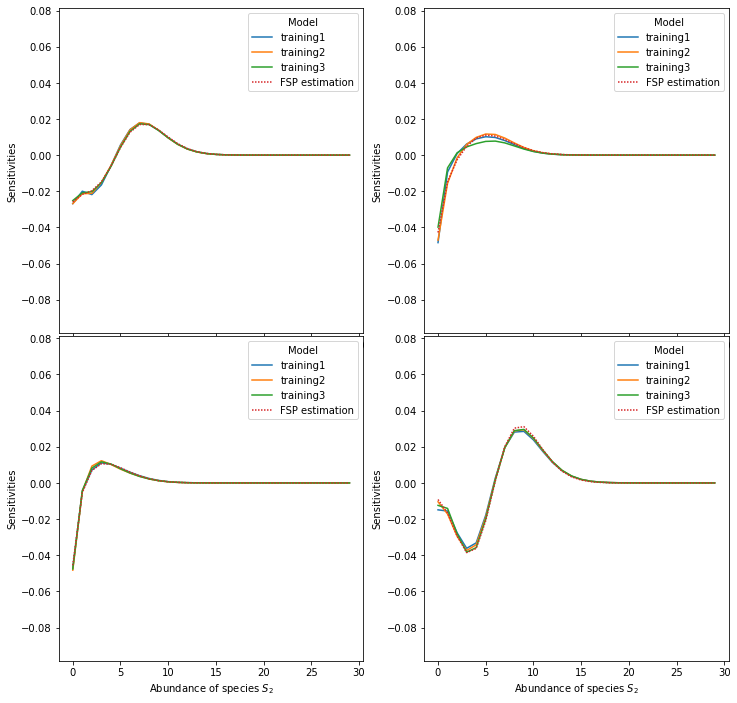

In [9]:
plot.multiple_plots(to_pred=[X_test[1_000+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound=[30]*4, 
                    time_windows=np.array([5, 10, 15, 20]),
                    n_comps=N_COMPS,
                    plot=('sensitivities', 1), 
                    plot_fsp_result=(True, 
                                    propensities.stoich_mat, 
                                    propensities.propensities, 
                                    None,
                                    50, 
                                    propensities.init_state, 
                                    1, 
                                    3, 
                                    1),
                    index_names=('Sensitivities', r'Abundance of species $S_2$'),
                    save=(False, 'CRN4_theta2.pdf'))

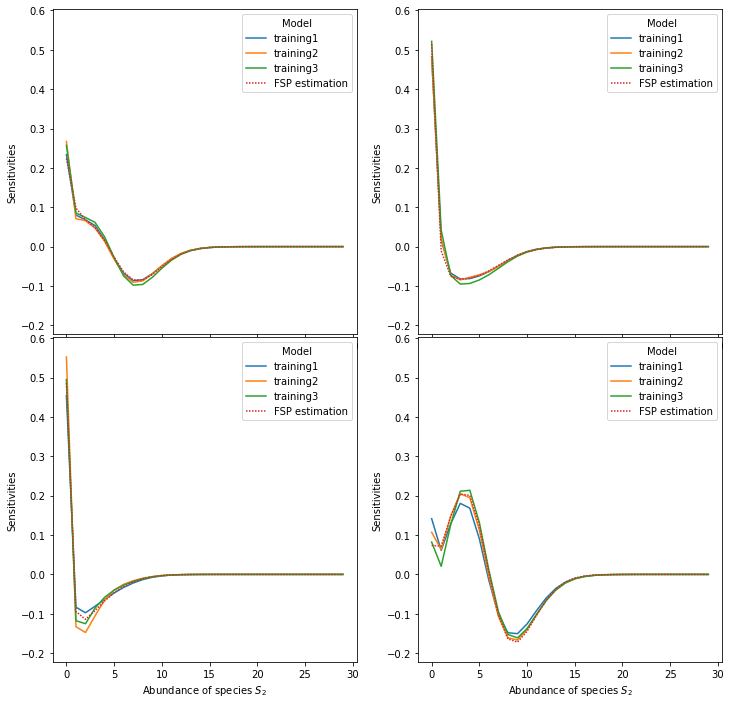

In [10]:
plot.multiple_plots(to_pred=[X_test[1_000+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound=[30]*4, 
                    time_windows=np.array([5, 10, 15, 20]),
                    n_comps=N_COMPS,
                    plot=('sensitivities', 2), 
                    plot_fsp_result=(True, 
                                    propensities.stoich_mat, 
                                    propensities.propensities, 
                                    None,
                                    50, 
                                    propensities.init_state, 
                                    1, 
                                    3, 
                                    1),
                    index_names=('Sensitivities', r'Abundance of species $S_2$'),
                    save=(False, 'CRN4_theta3.pdf'))

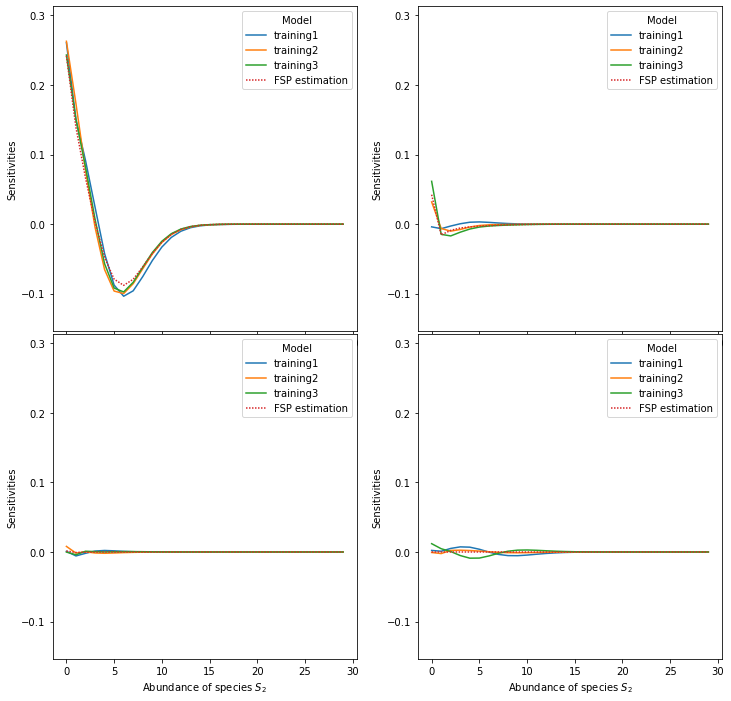

In [11]:
plot.multiple_plots(to_pred=[X_test[1_000+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound=[30]*4, 
                    time_windows=np.array([5, 10, 15, 20]),
                    n_comps=N_COMPS,
                    plot=('sensitivities', 3), 
                    plot_fsp_result=(True, 
                                    propensities.stoich_mat, 
                                    propensities.propensities, 
                                    None,
                                    50, 
                                    propensities.init_state, 
                                    1, 
                                    3, 
                                    1),
                    index_names=('Sensitivities', r'Abundance of species $S_2$'),
                    save=(False, 'CRN4_xi1.pdf'))

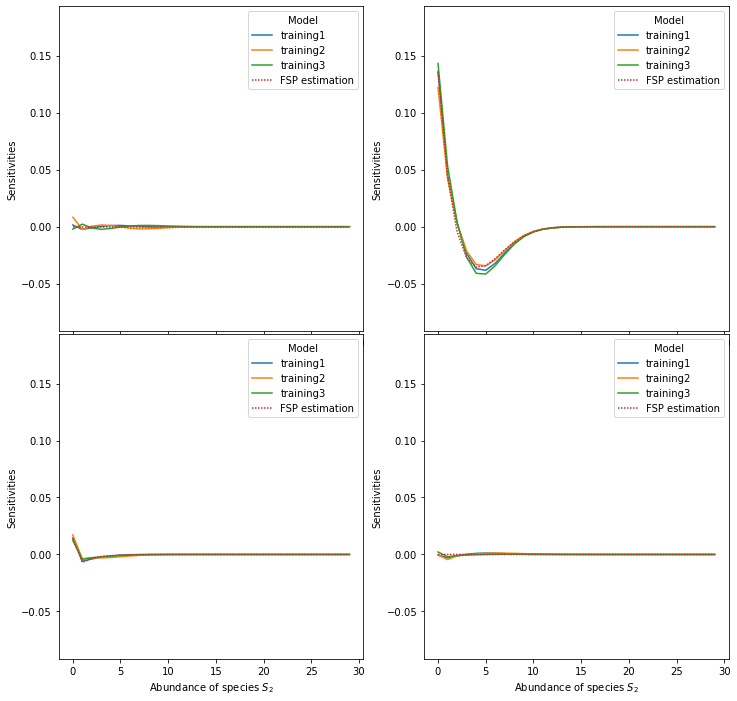

In [12]:
plot.multiple_plots(to_pred=[X_test[1_000+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound=[30]*4, 
                    time_windows=np.array([5, 10, 15, 20]),
                    n_comps=N_COMPS,
                    plot=('sensitivities', 4), 
                    plot_fsp_result=(True, 
                                    propensities.stoich_mat, 
                                    propensities.propensities, 
                                    None,
                                    50, 
                                    propensities.init_state, 
                                    1, 
                                    3, 
                                    1),
                    index_names=('Sensitivities', r'Abundance of species $S_2$'),
                    save=(False, 'CRN4_xi2.pdf'))

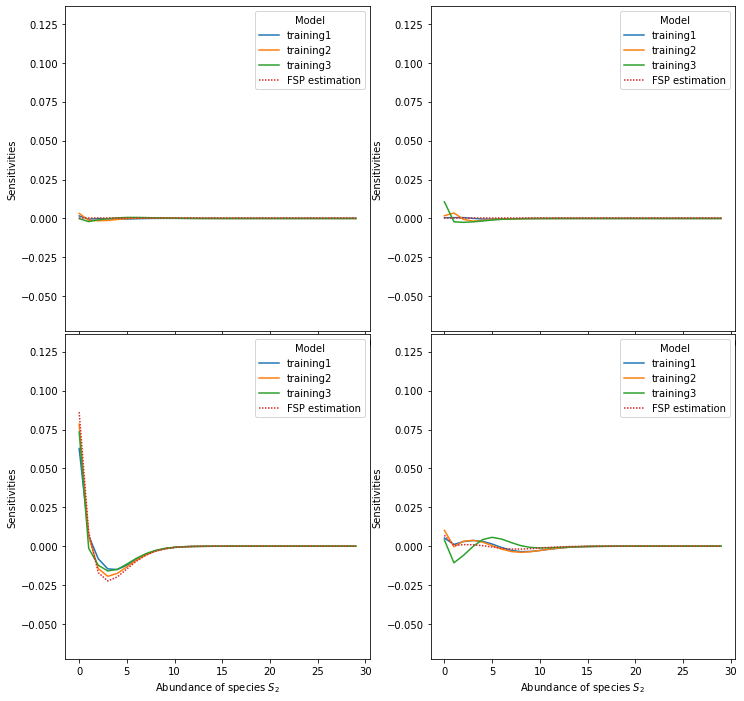

In [13]:
plot.multiple_plots(to_pred=[X_test[1_000+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound=[30]*4, 
                    time_windows=np.array([5, 10, 15, 20]),
                    n_comps=N_COMPS,
                    plot=('sensitivities', 5), 
                    plot_fsp_result=(True, 
                                    propensities.stoich_mat, 
                                    propensities.propensities, 
                                    None,
                                    50, 
                                    propensities.init_state, 
                                    1, 
                                    3, 
                                    1),
                    index_names=('Sensitivities', r'Abundance of species $S_2$'),
                    save=(False, 'CRN4_xi3.pdf'))

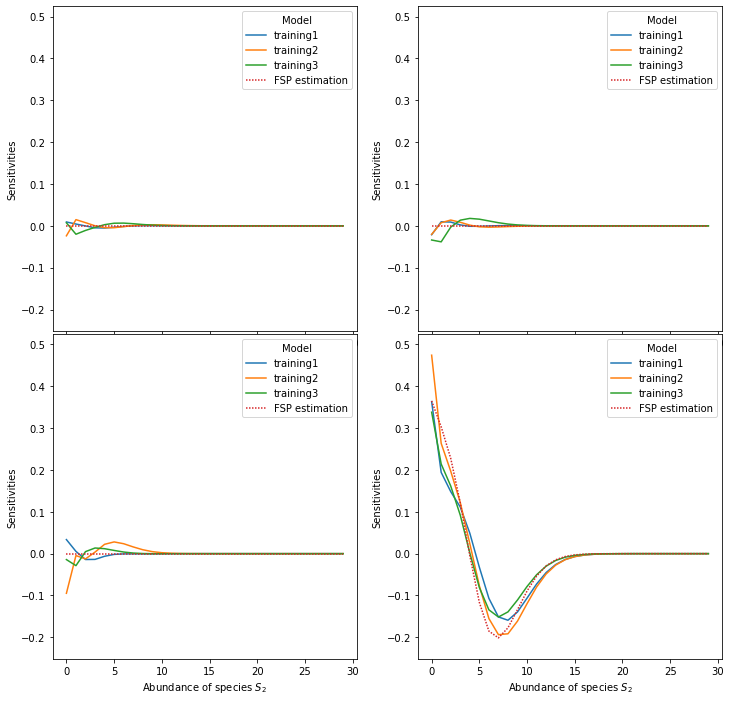

In [14]:
plot.multiple_plots(to_pred=[X_test[1_000+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound=[30]*4, 
                    time_windows=np.array([5, 10, 15, 20]),
                    n_comps=N_COMPS,
                    plot=('sensitivities', 6), 
                    plot_fsp_result=(True, 
                                    propensities.stoich_mat, 
                                    propensities.propensities, 
                                    None,
                                    50, 
                                    propensities.init_state, 
                                    1, 
                                    3, 
                                    1),
                    index_names=('Sensitivities', r'Abundance of species $S_2$'),
                    save=(False, 'CRN4_xi4.pdf'))

## Fisher information

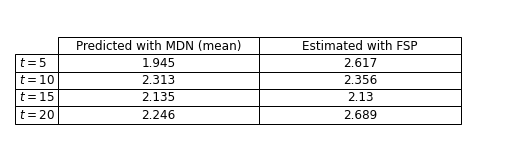

In [15]:
plot.fi_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=0,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200)

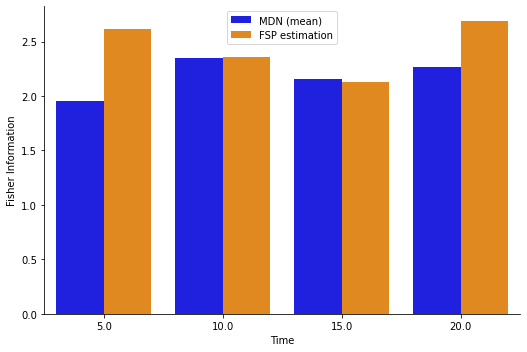

In [16]:
plot.fi_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=0,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200,
            colors=['blue', 'darkorange', 'forestgreen'])

In [17]:
plot.fi_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=1,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200)

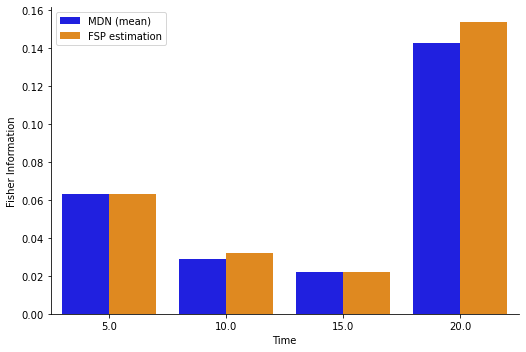

In [ ]:
plot.fi_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=1,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200,
            colors=['blue', 'darkorange', 'forestgreen'])

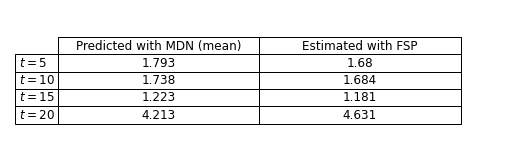

In [ ]:
plot.fi_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=2,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200)

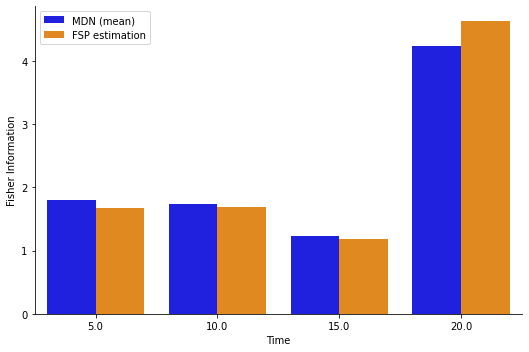

In [ ]:
plot.fi_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=2,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200,
            colors=['blue', 'darkorange', 'forestgreen'])

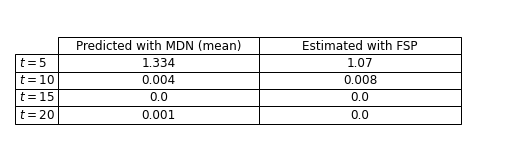

In [ ]:
plot.fi_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=3,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200)

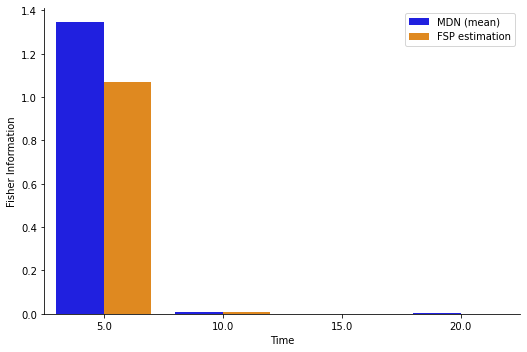

In [ ]:
plot.fi_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=3,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200,
            colors=['blue', 'darkorange', 'forestgreen'])

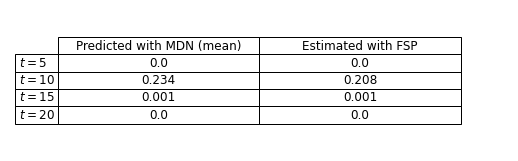

In [ ]:
plot.fi_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=4,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200)

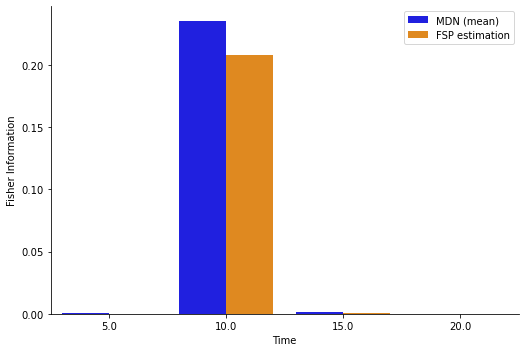

In [ ]:
plot.fi_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=4,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200,
            colors=['blue', 'darkorange', 'forestgreen'])

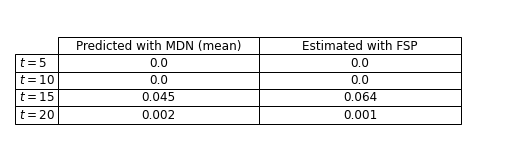

In [ ]:
plot.fi_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=5,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200)

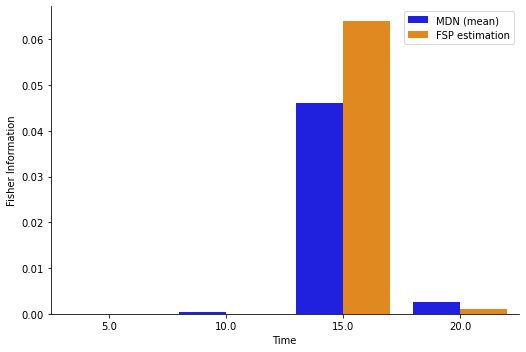

In [ ]:
plot.fi_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=5,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200,
            colors=['blue', 'darkorange', 'forestgreen'])

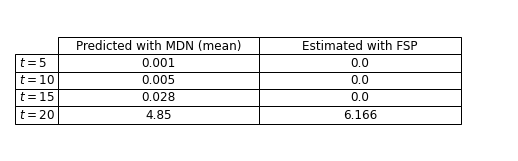

In [ ]:
plot.fi_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=6,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200)

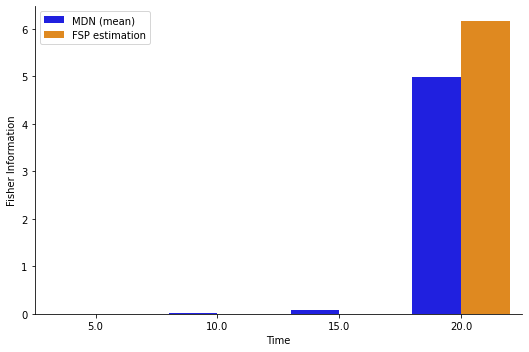

In [ ]:
plot.fi_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            ind_param=6,
            time_windows = np.array([5, 10, 15, 20]),
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            1, 
                            3, 
                            1),
            up_bound=200,
            colors=['blue', 'darkorange', 'forestgreen'])

## Expectation value

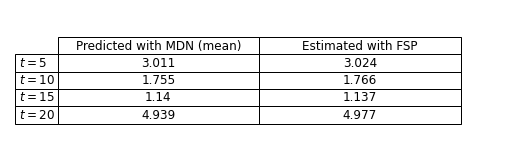

In [ ]:
plot.expect_val_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            up_bound=200,
            save=(True, 'CRN4_expval_tab.pdf'))

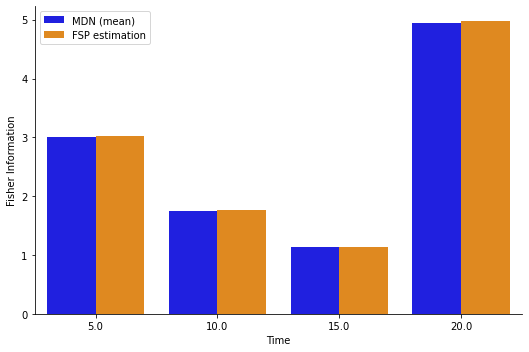

In [ ]:
plot.expect_val_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(),
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            up_bound=200,
            save=(True, 'CRN4_expval_bars.pdf'))

## Gradient of expectation

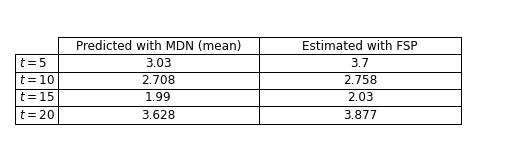

In [ ]:
plot.expect_val_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 0),
            up_bound=200,
            save=(True, 'CRN4_expgrad1_tab.pdf'))

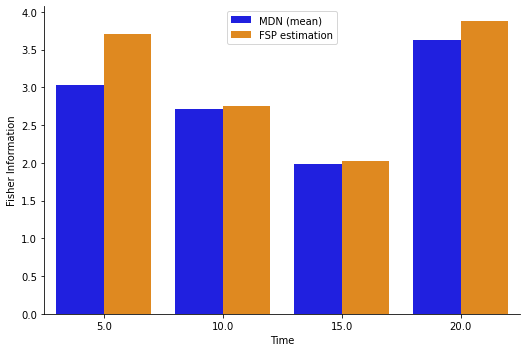

In [ ]:
plot.expect_val_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(),
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 0),
            up_bound=200,
            save=(True, 'CRN4_expgrad1_bars.pdf'))

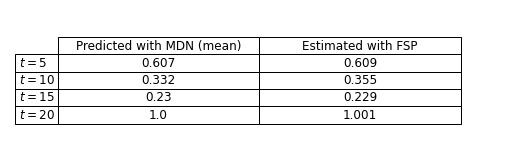

In [ ]:
plot.expect_val_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 1),
            up_bound=200,
            save=(True, 'CRN4_expgrad2_tab.pdf'))

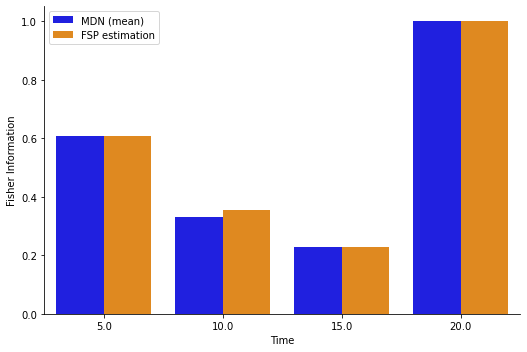

In [ ]:
plot.expect_val_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(),
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 1),
            up_bound=200,
            save=(True, 'CRN4_expgrad2_bars.pdf'))

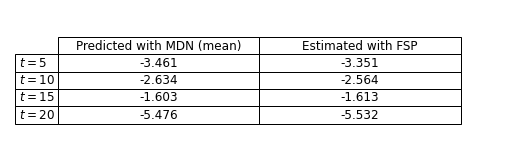

In [ ]:
plot.expect_val_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 2),
            up_bound=200,
            save=(True, 'CRN4_expgrad3_tab.pdf'))

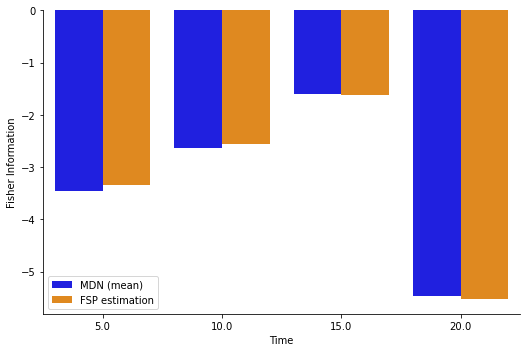

In [ ]:
plot.expect_val_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(),
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 2),
            up_bound=200,
            save=(True, 'CRN4_expgrad3_bars.pdf'))

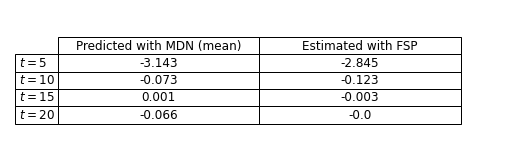

In [ ]:
plot.expect_val_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 3),
            up_bound=200,
            save=(True, 'CRN4_expgrad4_tab.pdf'))

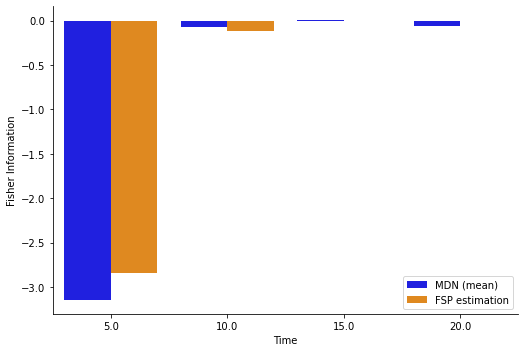

In [ ]:
plot.expect_val_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(),
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 3),
            up_bound=200,
            save=(True, 'CRN4_expgrad4_bars.pdf'))

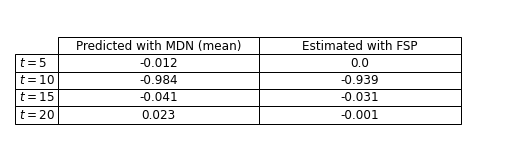

In [ ]:
plot.expect_val_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 4),
            up_bound=200,
            save=(True, 'CRN4_expgrad5_tab.pdf'))

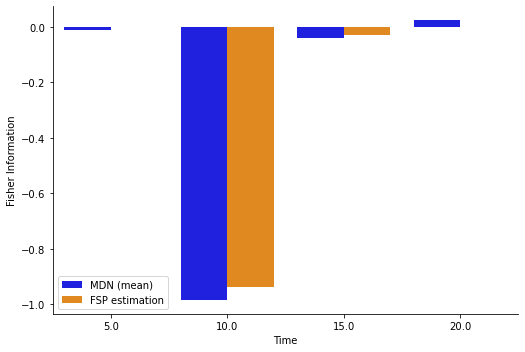

In [ ]:
plot.expect_val_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(),
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            propensities.propensities_drv,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 4),
            up_bound=200,
            save=(True, 'CRN4_expgrad5_bars.pdf'))

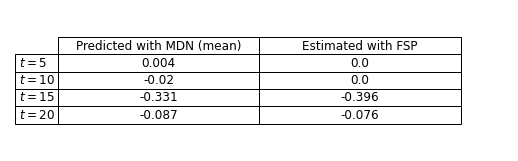

In [ ]:
plot.expect_val_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 5),
            up_bound=200,
            save=(True, 'CRN4_expgrad6_tab.pdf'))

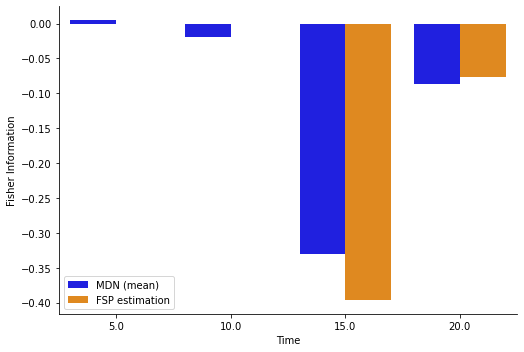

In [ ]:
plot.expect_val_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(),
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 5),
            up_bound=200,
            save=(True, 'CRN4_expgrad6_bars.pdf'))

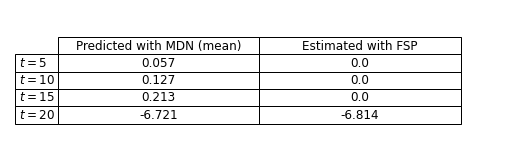

In [ ]:
plot.expect_val_table(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(), 
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 6),
            up_bound=200,
            save=(True, 'CRN4_expgrad7_tab.pdf'))

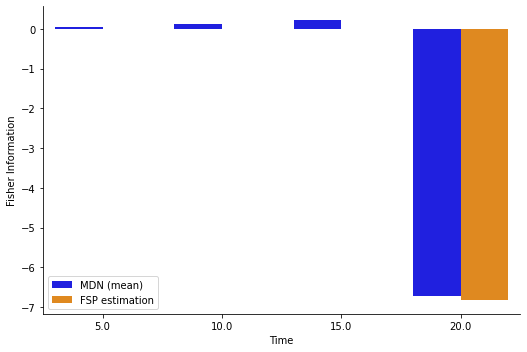

In [ ]:
plot.expect_val_barplots(time_samples=np.array([5, 10, 15, 20]), 
            params=X_test[1_000,1:].numpy(),
            time_windows=np.array([5, 10, 15, 20]),
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp_result=(True, 
                            propensities.stoich_mat, 
                            propensities.propensities, 
                            None,
                            400, 
                            propensities.init_state, 
                            propensities.ind_species, 
                            3, 
                            1),
            plot=('gradient', 6),
            up_bound=200,
            save=(True, 'CRN4_expgrad7_bars.pdf'))

## Control

In [ ]:
def loss05(x):
    return (x-0.5)**2

def loss1(x):
    return (x-1)**2

def loss1_5(x):
    return (x-1.5)**2

def loss1_75(x):
    return (x-1.75)**2

In [10]:
crn = simulation.CRN(stoichiometry_mat=propensities.stoich_mat, 
                    propensities=propensities.propensities, 
                    init_state=propensities.init_state, 
                    n_fixed_params=3, 
                    n_control_params=1)
domain=np.stack([np.array([1e-10, 5.])]*4)
fixed_params=np.array([1., 2., 1.])
time_windows=np.array([5, 10, 15, 20])

### Constant targets

Optimizing ...: 100%|██████████| 20000/20000 [03:50<00:00, 86.64it/s]


Time:  230.8754210472107
Control parameters:  [1.20701145 0.37442957 0.0177341  0.00276801]
Final loss:  0.38678530703373326


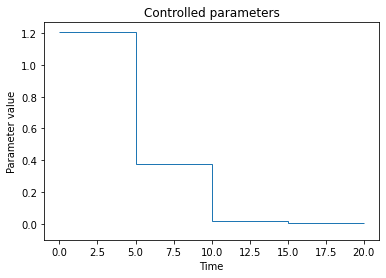

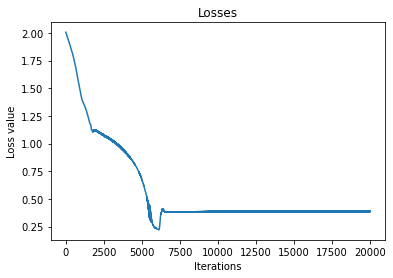

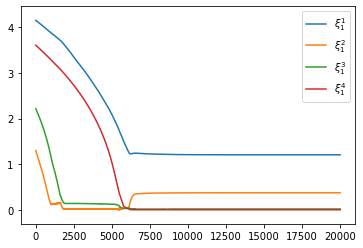

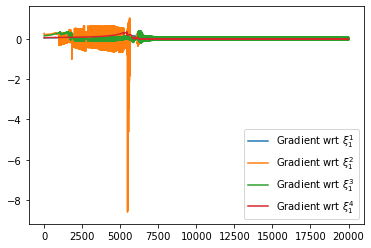

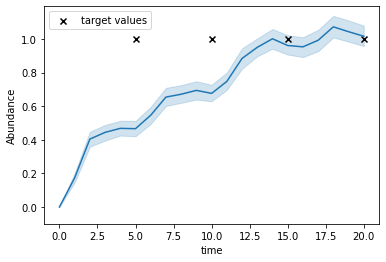

In [14]:
training_pgd.pgdMDN(crn=crn,
                    model=model,
                    domain=domain,
                    fixed_params=fixed_params,
                    time_windows=time_windows,
                    loss=loss05,
                    gamma=0.01,
                    n_iter=20_000,
                    eps=1e-7,
                    ind_species=propensities.ind_species,
                    targets=np.array([[5., 0.5], [10., 0.5], [15., 0.5], [20., 0.5]]),
                    crn_name='CRN4')

In [ ]:
training_pgd.pgdMDN(crn=crn,
                    model=model,
                    domain=domain,
                    fixed_params=fixed_params,
                    time_windows=time_windows,
                    loss=loss1,
                    gamma=0.01,
                    n_iter=20_000,
                    eps=1e-7,
                    ind_species=propensities.ind_species,
                    targets=np.array([[5., 1.], [10., 1.], [15., 1.], [20., 1.]]),
                    crn_name='CRN4')

In [ ]:
training_pgd.pgdMDN(crn=crn,
                    model=model,
                    domain=domain,
                    fixed_params=fixed_params,
                    time_windows=time_windows,
                    loss=loss1_5,
                    gamma=0.01,
                    n_iter=20_000,
                    eps=1e-7,
                    ind_species=propensities.ind_species,
                    targets=np.array([[5., 1.5], [10., 1.5], [15., 1.5], [20., 1.5]]),
                    crn_name='CRN4')

In [ ]:
training_pgd.pgdMDN(crn=crn,
                    model=model,
                    domain=domain,
                    fixed_params=fixed_params,
                    time_windows=time_windows,
                    loss=loss1_75,
                    gamma=0.01,
                    n_iter=20_000,
                    eps=1e-7,
                    ind_species=propensities.ind_species,
                    targets=np.array([[5., 1.75], [10., 1.75], [15., 1.75], [20., 1.75]]),
                    crn_name='CRN4')